In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from IPython.display import clear_output

In [2]:
BOARD_SIZE = (12, 24)
INITIAL_TREASURES = 4

In [3]:
class Game:
    def __init__(self, player_names, player_colors, board_size=BOARD_SIZE, initial_treasures = INITIAL_TREASURES):
        self.initial_treasures = initial_treasures
        self.board_size = board_size
        self.ship_position = (np.array(board_size) / 2).astype(int)
        self.board = - np.ones(board_size, dtype=int)
        
        self.n_players = len(player_names)
        self.player_names = player_names
        self.player_colors = player_colors
        self.on_board = np.zeros((self.n_players, initial_treasures), dtype = bool)
        self.taken = np.zeros((self.n_players, initial_treasures), dtype = bool)
        self.positions = np.zeros((self.n_players, initial_treasures, 2), dtype = int)
        
        self.cmap = mpl.colors.ListedColormap(['white'] + player_colors)
        self.norm = mpl.colors.BoundaryNorm(range(-1, self.n_players + 1), self.cmap.N)
        
        self.current_moves = np.zeros((self.n_players, 2), dtype=int)
        self.current_player = 0
        self.current_turn = 0
        self.phase = 'Blowing'
        self.winner = np.zeros(self.n_players, dtype = bool)
    
    def move_treasure(self, treasure, ans):
        try:
            if self.taken[self.current_player, treasure]:
                return False
            
            new_position = ans.split(',')[::-1]
            if len(new_position) != 2:
                return False
            new_position = [int(i) for i in new_position]
            
            
            if self.board[new_position[0], new_position[1]] != -1:
                return False
            
            if self.on_board[self.current_player, treasure]:
                self.board[self.positions[self.current_player, treasure, 0], self.positions[self.current_player, treasure, 1]] = -1
            self.on_board[self.current_player, treasure] = True
            self.positions[self.current_player, treasure] = new_position
            self.board[new_position[0], new_position[1]] = self.current_player
            self.current_player += 1
            return True
        except:
            return False
    
    def is_valid_blow(self, ans):
        if len(ans.split(',')) != 2:
            return False
        
        try:
            blow = [int(i) for i in ans.split(',')]
            if sum(np.abs(blow)) <= 3:
                self.current_moves[self.current_player] = blow[::-1]
                return True
            else:
                return False
        except:
            return False
    
    def is_valid_treasure(self, ans):
        try:
            t = int(ans)
            if t > self.initial_treasures:
                return False
            if self.taken[self.current_player, t]:
                return False
            return True
        except:
            return False
    
    def plot_board(self, player=None, show_ship=True):
        fig, axes = plt.subplots(1, 2, figsize=(16,10), gridspec_kw={'width_ratios': [1, 6]})

        cell_text = []
        for n, t in zip(self.player_names, self.taken):
            cell_text.append([n, t.sum()])

        axes[0].table(cell_text, colLabels=['Player', 'Points'], loc = 'center')
        axes[0].set_axis_off()
        
        ax = axes[1]
        ax.imshow(self.board, interpolation='none', cmap = self.cmap, norm = self.norm)
        ax.invert_yaxis()
        ax.set_yticks(np.arange(-0.5, self.board.shape[0]-1), labels = [])
        ax.set_xticks(np.arange(-0.5, self.board.shape[1]-1), labels = [])
        
        ax.set_yticks(np.arange(self.board.shape[0]), labels = np.arange(self.board.shape[0]), minor=True)
        ax.set_xticks(np.arange(self.board.shape[1]), labels = np.arange(self.board.shape[1]), minor=True)
        ax.grid()
        
        if show_ship:
            ax.plot(*(self.ship_position[::-1]), 'ko', markersize=20)
    
        fig.suptitle(
            f"Prrrrinha - Turn: {self.current_turn}   Phase: {self.phase}", 
            y=0.8
        )
        if player != None:
            not_on_board = np.arange(self.initial_treasures)[np.logical_not(self.taken[player]) & np.logical_not(self.on_board[player])]
            ax.set_title(f"Treasures not on board of {self.player_names[player]}: {not_on_board}")
            for i in range(self.initial_treasures):
                if self.on_board[player, i] and not self.taken[player, i]:
                    ax.annotate(i, self.positions[player, i, ::-1], 
                                ha='center', va='center', size=15, 
                                bbox=dict(boxstyle="round", fc="w", alpha=0.3)
                               )
        return fig, ax
    
    def move_ship(self):
        self.ship_position += self.current_moves.sum(0)
        
        if self.ship_position[0] < 0:
            self.ship_position[0] = 0
        if self.ship_position[1] < 0:
            self.ship_position[1] = 0
        
        if self.ship_position[0] >= self.board.shape[0]:
            self.ship_position[0] = self.board.shape[0] - 1
        if self.ship_position[1] >= self.board.shape[1]:
            self.ship_position[1] = self.board.shape[1] - 1
        
    def update(self):
        ans = ""
        if self.phase == 'Blowing':
            while not self.is_valid_blow(ans):
                fig, ax = self.plot_board(self.current_player)
                plt.show()
                ans = input(f"{self.player_names[self.current_player]}, type the movement (x,y) (|x| + |y| < 4): ")
                clear_output()
            self.current_player += 1
        else:
            while True:
                fig, ax = self.plot_board(self.current_player)
                plt.show()
                ans = input(f"{self.player_names[self.current_player]}, choose a treasure: ")
                
                if not self.is_valid_treasure(ans):
                    clear_output()
                    continue
                t = int(ans)
                
                ans = input(f"{self.player_names[self.current_player]}, choose the new position for treasure {t}: ")
                if self.move_treasure(t, ans):
                    break
                clear_output()
        
        if self.current_player == self.n_players:
            self.current_player = 0
            if self.phase == 'Blowing':
                self.phase = 'Positioning'
            elif self.phase == 'Positioning':
                self.move_ship()
                self.phase = 'Collecting'
                clear_output()
                self.plot_board()
                plt.show()
                input("Press ENTER to continue")
                self.phase = 'Blowing'
                self.taken = self.taken | ((np.linalg.norm(self.positions - self.ship_position, 1, 2) <= 1) & self.on_board)
                self.on_board[self.taken] = False
                for i in self.positions[self.taken]:
                    self.board[i[0], i[1]] = -1
                self.current_turn += 1
            
            self.winner = np.all(self.taken, 1)
            if np.any(self.winner):
                print(f"Player {self.player_names[self.winner]} is the winner!")

In [9]:
player_names = ['Player1', 'Player2']
player_colors = ['blue', 'green']

self = Game(player_names, player_colors)

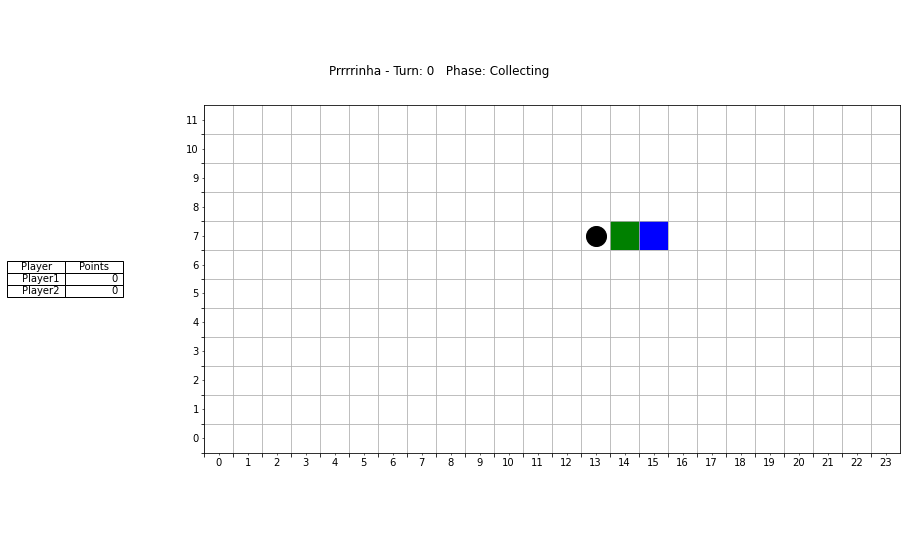

In [ ]:
while True:
    clear_output()
    self.update()